In [4]:
import os, shutil, math, warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from glob import glob
from tabulate import tabulate
from datetime import datetime, timedelta
from fastai.tabular.core import add_datepart

# Seaborn style settings
sns.set_theme(style="ticks", palette="mako")

In [5]:
# Master datasets paths
paths = glob("data/*.csv")

# Reading master datasets
datasets = {}
for path in paths:
    ds = str(path[5:-4])
    datasets[ds] = pd.read_csv(path)
    # Converting datetime column
    datasets[ds]["DATE_PST"] = pd.to_datetime(datasets[ds]["DATE_PST"])
    # Creating datepart features
    datasets[ds] = add_datepart(
        datasets[ds], "DATE_PST", drop=False, prefix="", time=True
    )
    datasets[ds].drop(
        [
            "Is_month_end",
            "Is_month_start",
            "Is_quarter_end",
            "Is_quarter_start",
            "Is_year_end",
            "Is_year_start",
            "Elapsed",
            "Minute",
            "Second",
        ],
        axis=1,
        inplace=True,
    )

datasets_list = sorted(list(datasets.keys()))
datasets_list

['North_Vancouver_Mahon_Park',
 'North_Vancouver_Second_Narrows',
 'Vancouver_Clark_Drive',
 'Vancouver_International_Airport_#2']

In [6]:
# Dataset dimensions
for dataset in datasets_list:
    print(f"{datasets[dataset].shape} dim. for {dataset} dataset.")

(57014, 9) dim. for North_Vancouver_Mahon_Park dataset.
(57014, 9) dim. for North_Vancouver_Second_Narrows dataset.
(57014, 9) dim. for Vancouver_Clark_Drive dataset.
(57014, 9) dim. for Vancouver_International_Airport_#2 dataset.


In [7]:
print(
    tabulate(
        datasets["North_Vancouver_Mahon_Park"].head(), headers="keys", tablefmt="psql"
    )
)

+----+---------------------+-------------+--------+---------+--------+-------+-------------+-------------+--------+
|    | DATE_PST            |   RAW_VALUE |   Year |   Month |   Week |   Day |   Dayofweek |   Dayofyear |   Hour |
|----+---------------------+-------------+--------+---------+--------+-------+-------------+-------------+--------|
|  0 | 2016-01-01 01:00:00 |    22.7989  |   2016 |       1 |     53 |     1 |           4 |           1 |      1 |
|  1 | 2016-01-01 02:00:00 |    22.9091  |   2016 |       1 |     53 |     1 |           4 |           1 |      2 |
|  2 | 2016-01-01 03:00:00 |    19.8577  |   2016 |       1 |     53 |     1 |           4 |           1 |      3 |
|  3 | 2016-01-01 04:00:00 |    13.576   |   2016 |       1 |     53 |     1 |           4 |           1 |      4 |
|  4 | 2016-01-01 05:00:00 |     7.07959 |   2016 |       1 |     53 |     1 |           4 |           1 |      5 |
+----+---------------------+-------------+--------+---------+--------+--

In [8]:
# Looking for negative PM 2.5 values
for dataset in datasets_list:
    print(min(datasets[dataset]["RAW_VALUE"]))

0.0
nan
-0.6341805
0.0


In [9]:
datasets["Vancouver_Clark_Drive"][datasets["Vancouver_Clark_Drive"]["RAW_VALUE"] < 0]

,DATE_PST,RAW_VALUE,Year,Month,Week,Day,Dayofweek,Dayofyear,Hour
19874,2018-04-08 03:00:00,-0.028597,2018,4,14,8,6,98,3
51793,2021-11-28 02:00:00,-0.320931,2021,11,47,28,6,332,2
51794,2021-11-28 03:00:00,-0.604097,2021,11,47,28,6,332,3
51795,2021-11-28 04:00:00,-0.634181,2021,11,47,28,6,332,4
51796,2021-11-28 05:00:00,-0.438903,2021,11,47,28,6,332,5
51800,2021-11-28 09:00:00,-0.091346,2021,11,47,28,6,332,9
54003,2022-02-28 04:00:00,-0.030625,2022,2,9,28,0,59,4


In [10]:
# Setting negative values a NaN
for dataset in datasets_list:
    datasets[dataset][datasets[dataset]["RAW_VALUE"] < 0] = math.nan

### Visualizing missing values
* How missing values are plotted with standard visualizations

In [11]:
# Missing value section
subset = datasets["North_Vancouver_Mahon_Park"][
    (datasets["North_Vancouver_Mahon_Park"]["DATE_PST"] >= datetime(2016, 3, 22, 18))
    & (datasets["North_Vancouver_Mahon_Park"]["DATE_PST"] <= datetime(2016, 3, 24, 18))
]

print(tabulate(subset, headers="keys", tablefmt="psql"))

+------+---------------------+-------------+--------+---------+--------+-------+-------------+-------------+--------+
|      | DATE_PST            |   RAW_VALUE |   Year |   Month |   Week |   Day |   Dayofweek |   Dayofyear |   Hour |
|------+---------------------+-------------+--------+---------+--------+-------+-------------+-------------+--------|
| 1961 | 2016-03-22 18:00:00 |    2.29019  |   2016 |       3 |     12 |    22 |           1 |          82 |     18 |
| 1962 | 2016-03-22 19:00:00 |    1.91071  |   2016 |       3 |     12 |    22 |           1 |          82 |     19 |
| 1963 | 2016-03-22 20:00:00 |    2.72774  |   2016 |       3 |     12 |    22 |           1 |          82 |     20 |
| 1964 | 2016-03-22 21:00:00 |    1.96188  |   2016 |       3 |     12 |    22 |           1 |          82 |     21 |
| 1965 | 2016-03-22 22:00:00 |    1.48958  |   2016 |       3 |     12 |    22 |           1 |          82 |     22 |
| 1966 | 2016-03-22 23:00:00 |    1.04685  |   2016 |   

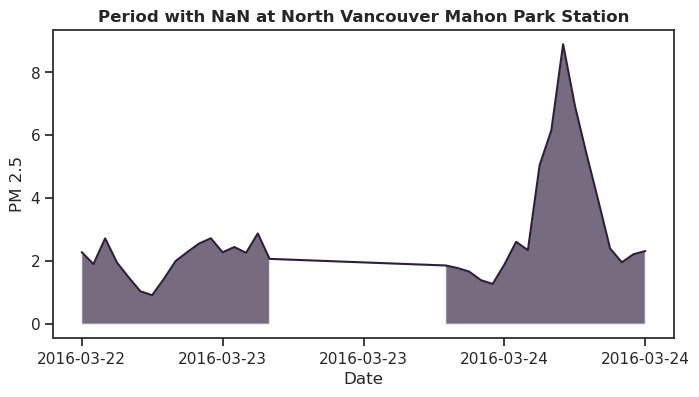

In [12]:
# Standard visualization with seaborn lineplot
plt.figure(figsize=(8, 4))

# Lineplot
l = sns.lineplot(x="DATE_PST", y="RAW_VALUE", data=subset)
# Filling values to indicate NaN
l.fill_between(x="DATE_PST", y1="RAW_VALUE", data=subset, alpha=0.65)
l.set_title(
    "Period with NaN at North Vancouver Mahon Park Station",
    fontsize=12,
    fontweight="bold",
)
l.set_ylabel("PM 2.5")
l.set_xlabel("Date")
l.set_xticks(l.get_xticks()[::2])
plt.show()

In [13]:
# Dummy variable to keep track of missing samples and missing sample length
for dataset in datasets_list:
    datasets[dataset]["MISSING"] = np.where(
        datasets[dataset]["RAW_VALUE"].isnull(), 1, 0
    )

datasets["North_Vancouver_Mahon_Park"].head()

,DATE_PST,RAW_VALUE,Year,Month,Week,Day,Dayofweek,Dayofyear,Hour,MISSING
0,2016-01-01 01:00:00,22.798870,2016.0,1.0,53.0,1.0,4.0,1.0,1.0,0
1,2016-01-01 02:00:00,22.909090,2016.0,1.0,53.0,1.0,4.0,1.0,2.0,0
2,2016-01-01 03:00:00,19.857730,2016.0,1.0,53.0,1.0,4.0,1.0,3.0,0
3,2016-01-01 04:00:00,13.575990,2016.0,1.0,53.0,1.0,4.0,1.0,4.0,0
4,2016-01-01 05:00:00,7.079589,2016.0,1.0,53.0,1.0,4.0,1.0,5.0,0


In [14]:
# Identifying isolated missing values and continuous missing values
# Auxiliar column to identify missing value interval lengths

for dataset in datasets_list:
    # Initialize missing value sequency array and maximum sequence length
    nan_seq_length = np.zeros(
        (
            len(
                datasets[dataset],
            )
        )
    )
    seq_max = 0
    for i in range(0, len(datasets[dataset])):
        seq = 0  # Sequence counter
        if not datasets[dataset].loc[i, "MISSING"]:
            breakpoint = (
                i - 1
            )  # Store previous id when entering a missing value sequence
        while datasets[dataset].loc[i, "MISSING"]:
            i += 1  # Add up to iterator while still missing
            seq += 1  # Add up to sequence length while still missing
        if seq:  # Check if in a missing sequence
            if seq_max < seq:  # If max sequence length < current sequence
                seq_max = seq  # Update maximum sequence length
        else:
            seq_max = 0  # If not in a missing sequence reset max sequence lenght
        # Update sequence length array with maximum sequence length
        nan_seq_length[(i - seq)] = seq_max
    datasets[dataset]["MISSING_SEQ"] = nan_seq_length.astype(int)

In [15]:
datasets["North_Vancouver_Mahon_Park"].iloc[
    np.where(datasets["North_Vancouver_Mahon_Park"]["MISSING"])
].head(20)

,DATE_PST,RAW_VALUE,Year,Month,Week,Day,Dayofweek,Dayofyear,Hour,MISSING,MISSING_SEQ
831,2016-02-04 16:00:00,NaN,2016.0,2.0,5.0,4.0,3.0,35.0,16.0,1,1
1141,2016-02-17 14:00:00,NaN,2016.0,2.0,7.0,17.0,2.0,48.0,14.0,1,1
1978,2016-03-23 11:00:00,NaN,2016.0,3.0,12.0,23.0,2.0,83.0,11.0,1,14
1979,2016-03-23 12:00:00,NaN,2016.0,3.0,12.0,23.0,2.0,83.0,12.0,1,14
1980,2016-03-23 13:00:00,NaN,2016.0,3.0,12.0,23.0,2.0,83.0,13.0,1,14
1981,2016-03-23 14:00:00,NaN,2016.0,3.0,12.0,23.0,2.0,83.0,14.0,1,14
1982,2016-03-23 15:00:00,NaN,2016.0,3.0,12.0,23.0,2.0,83.0,15.0,1,14
1983,2016-03-23 16:00:00,NaN,2016.0,3.0,12.0,23.0,2.0,83.0,16.0,1,14
1984,2016-03-23 17:00:00,NaN,2016.0,3.0,12.0,23.0,2.0,83.0,17.0,1,14
1985,2016-03-23 18:00:00,NaN,2016.0,3.0,12.0,23.0,2.0,83.0,18.0,1,14


In [16]:
datasets["North_Vancouver_Second_Narrows"].iloc[
    np.where(datasets["North_Vancouver_Second_Narrows"]["MISSING"])
].head(20)

,DATE_PST,RAW_VALUE,Year,Month,Week,Day,Dayofweek,Dayofyear,Hour,MISSING,MISSING_SEQ
0,2016-01-01 01:00:00,NaN,2016.0,1.0,53.0,1.0,4.0,1.0,1.0,1,1
1757,2016-03-14 06:00:00,NaN,2016.0,3.0,11.0,14.0,0.0,74.0,6.0,1,3
1758,2016-03-14 07:00:00,NaN,2016.0,3.0,11.0,14.0,0.0,74.0,7.0,1,3
1759,2016-03-14 08:00:00,NaN,2016.0,3.0,11.0,14.0,0.0,74.0,8.0,1,3
1764,2016-03-14 13:00:00,NaN,2016.0,3.0,11.0,14.0,0.0,74.0,13.0,1,1
2125,2016-03-29 14:00:00,NaN,2016.0,3.0,13.0,29.0,1.0,89.0,14.0,1,1
2507,2016-04-14 12:00:00,NaN,2016.0,4.0,15.0,14.0,3.0,105.0,12.0,1,2
2508,2016-04-14 13:00:00,NaN,2016.0,4.0,15.0,14.0,3.0,105.0,13.0,1,2
3493,2016-05-25 14:00:00,NaN,2016.0,5.0,21.0,25.0,2.0,146.0,14.0,1,1
5120,2016-08-01 09:00:00,NaN,2016.0,8.0,31.0,1.0,0.0,214.0,9.0,1,26


In [17]:
# Master DataFrame
# Resetting MultiIndex
master_df = pd.concat(datasets).reset_index(level=0)
# Renaming station column
master_df["STATION"] = master_df["level_0"]
master_df.drop("level_0", axis=1, inplace=True)
# Resetting index to complete dataframe length
master_df.reset_index(drop=True, inplace=True)
master_df.head()

,DATE_PST,RAW_VALUE,Year,Month,Week,Day,Dayofweek,Dayofyear,Hour,MISSING,MISSING_SEQ,STATION
0,2016-01-01 01:00:00,22.798870,2016.0,1.0,53.0,1.0,4.0,1.0,1.0,0,0,North_Vancouver_Mahon_Park
1,2016-01-01 02:00:00,22.909090,2016.0,1.0,53.0,1.0,4.0,1.0,2.0,0,0,North_Vancouver_Mahon_Park
2,2016-01-01 03:00:00,19.857730,2016.0,1.0,53.0,1.0,4.0,1.0,3.0,0,0,North_Vancouver_Mahon_Park
3,2016-01-01 04:00:00,13.575990,2016.0,1.0,53.0,1.0,4.0,1.0,4.0,0,0,North_Vancouver_Mahon_Park
4,2016-01-01 05:00:00,7.079589,2016.0,1.0,53.0,1.0,4.0,1.0,5.0,0,0,North_Vancouver_Mahon_Park


### Thresholding missing sequence length
* Individual Missing Values (IMV)
* Continuous Missing Sample (CMS)

In [18]:
# Time threshold Tht
# MISSING_SEQ > Tht: Continuous missing samples (1)
# MISSING_SEQ <= Tht: Isolated missing value (0)
Tht = 6

master_df["MISSING_SAMPLE"] = np.where(master_df["MISSING_SEQ"] > Tht, 1, 0)

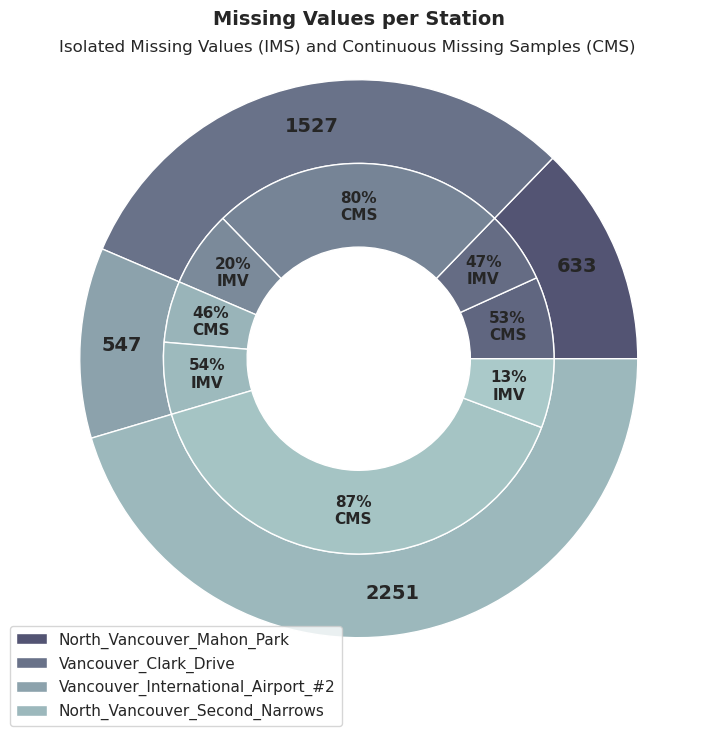

In [19]:
# Continuous missing samples // Isolated missing values count
stations = []
tot_missing = []
stations_cms_imv = []
stations_cms_imv_label = []

for station in pd.unique(master_df["STATION"]):
    stations.append(station)
    tot_missing_current = sum(master_df["MISSING"][master_df["STATION"] == station])
    tot_missing.append(tot_missing_current)
    tot_cms = sum(master_df["MISSING_SAMPLE"][master_df["STATION"] == station])
    stations_cms_imv.append(tot_cms)
    stations_cms_imv_label.append(f"{tot_cms/tot_missing_current * 100:.0f}%\nCMS")
    tot_imv = tot_missing_current - tot_cms
    stations_cms_imv.append(tot_imv)
    stations_cms_imv_label.append(f"{tot_imv/tot_missing_current * 100:.0f}%\nIMV")

# Stacked pie charts with IMV and CMS percentages
fig, ax = plt.subplots(figsize=(9, 9))
ax.axis("equal")
width = 0.3

cm = plt.get_cmap("bone")
cout = cm([95, 120, 160, 178])
pie, texts1 = ax.pie(
    tot_missing,
    radius=1,
    labels=tot_missing,
    colors=cout,
    labeldistance=0.85,
    textprops={"fontsize": 14, "weight": "bold"},
)
for t in texts1:
    t.set_horizontalalignment("center")
plt.legend(pie, stations, loc=(0, -0.03))
plt.setp(pie, width=width, edgecolor="white")

cin = cm(np.array([110, 115, 135, 140, 175, 180, 188, 193]))
pie2, texts2 = ax.pie(
    stations_cms_imv,
    radius=1 - width,
    labels=stations_cms_imv_label,
    labeldistance=0.78,
    colors=cin,
    textprops={"weight": "bold"},
)
for t in texts2:
    t.set_horizontalalignment("center")
plt.setp(pie2, width=width, edgecolor="white")
plt.title("Missing Values per Station", fontsize=14, weight="bold", y=0.97)
plt.suptitle(
    "Isolated Missing Values (IMS) and Continuous Missing Samples (CMS)",
    fontsize=12,
    y=0.85,
)
plt.show()

## Imputation of Missing Values
* IMV imputation with one-dimensional interpolation
* CMS imputation with LSTM

### Auxiliar Functions to search and plot IMV and CMS

In [168]:
from tshelpers.subset import subset_interval, create_missing
from tshelpers.plot import plot_sequence, plot_compare
from tshelpers.metrics import rmse_score

In [21]:
stations

['North_Vancouver_Mahon_Park',
 'Vancouver_Clark_Drive',
 'Vancouver_International_Airport_#2',
 'North_Vancouver_Second_Narrows']

In [23]:
station_subset = master_df[master_df["STATION"] == "North_Vancouver_Mahon_Park"]
interval = subset_interval(station_subset, missing_type="CMS", sequence_no=15)

Missing value sequences found with current argument:
+----+---------------------+---------------------+----------+
|    | Sequence Start      | Sequence End        | Length   |
|----+---------------------+---------------------+----------|
|  0 | 2016-03-23 11:00:00 | 2016-03-24 01:00:00 | 14 h     |
|  1 | 2016-07-26 11:00:00 | 2016-07-27 00:00:00 | 13 h     |
|  2 | 2016-08-17 11:00:00 | 2016-08-18 14:00:00 | 27 h     |
|  3 | 2017-05-12 05:00:00 | 2017-05-14 19:00:00 | 62 h     |
|  4 | 2017-05-17 13:00:00 | 2017-05-18 12:00:00 | 23 h     |
|  5 | 2017-07-07 19:00:00 | 2017-07-08 10:00:00 | 15 h     |
|  6 | 2017-09-13 14:00:00 | 2017-09-13 21:00:00 | 7 h      |
|  7 | 2018-06-23 04:00:00 | 2018-06-23 13:00:00 | 9 h      |
|  8 | 2018-11-04 15:00:00 | 2018-11-05 03:00:00 | 12 h     |
|  9 | 2019-03-10 07:00:00 | 2019-03-10 15:00:00 | 8 h      |
| 10 | 2019-05-27 14:00:00 | 2019-05-28 05:00:00 | 15 h     |
| 11 | 2019-07-03 08:00:00 | 2019-07-05 00:00:00 | 40 h     |
| 12 | 2019-07-17

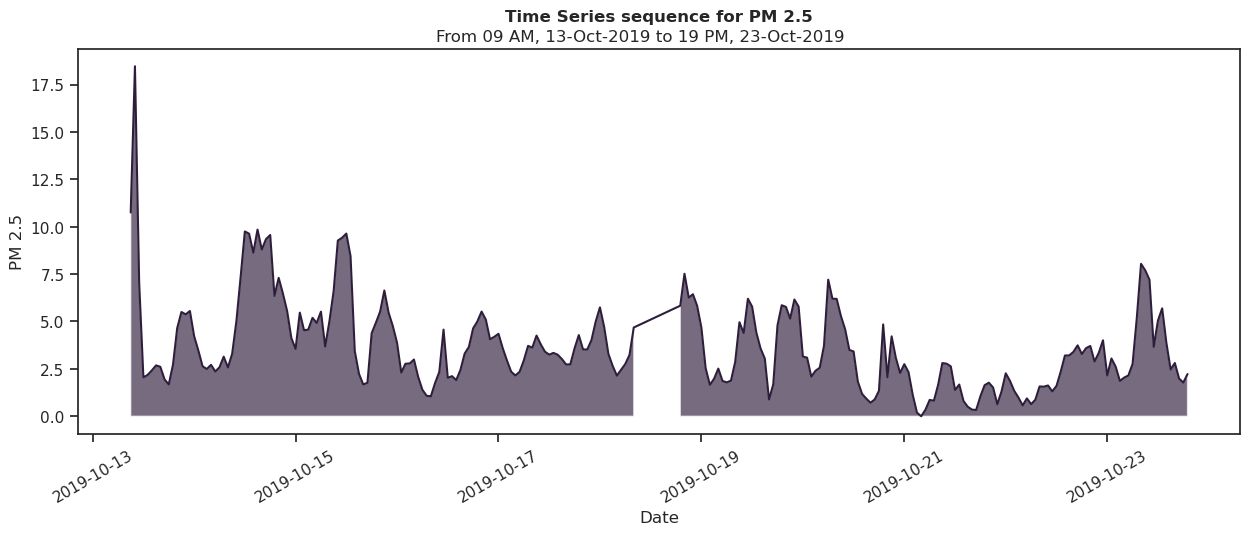

In [25]:
plot_sequence(data=station_subset, start=interval[0], end=interval[1])

### Generating Artificial Missing Data
Artificially missing data will be generated to evaluate imputation methods

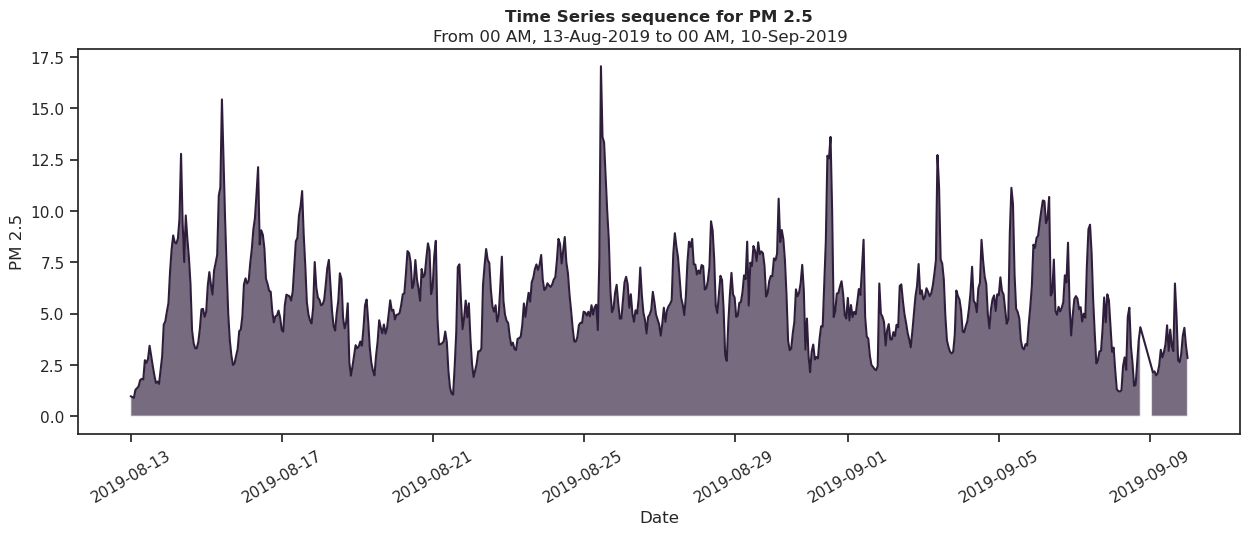

In [161]:
subset, subset_missing = create_missing(
    data=station_subset,
    start=datetime(2019, 8, 13),
    end=datetime(2019, 9, 10),
    missing_length=6,
    padding=24,
    missing_index='end'
)

plot_sequence(data=subset_missing)

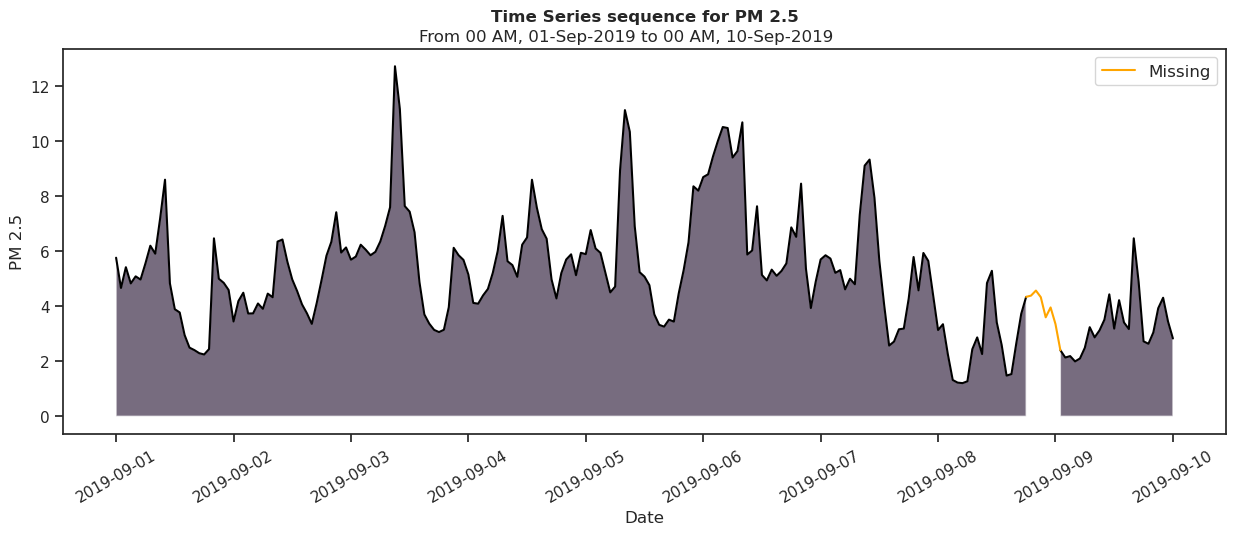

In [162]:
plot_compare(subset, subset_missing,
             start=datetime(2019, 9, 1),
             end=datetime(2019, 9, 10),
             fill=True)

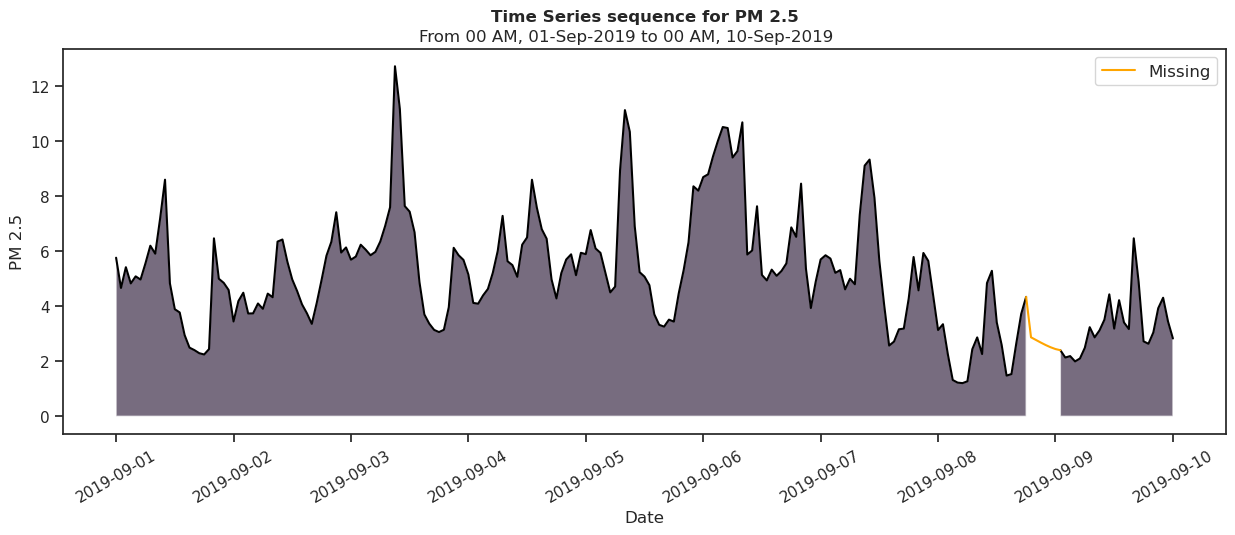

RMSE for RAW_VALUE: 0.1345


0.13449054893116916

In [163]:
subset_spline = subset.copy()
subset_spline['RAW_VALUE'] = subset_missing['RAW_VALUE'].interpolate(method = 'spline', order = 3).tolist()
plot_compare(subset_spline, subset_missing,
             start=datetime(2019, 9, 1),
             end=datetime(2019, 9, 10),
             fill=True)

rmse_score(subset, subset_spline)

In [169]:
plot_compare(subset_spline, subset, missing_only=False,
             start=datetime(2019, 9, 1),
             end=datetime(2019, 9, 10),
             fill=True,
             color='blue')

TypeError: plot_compare() got an unexpected keyword argument 'color'

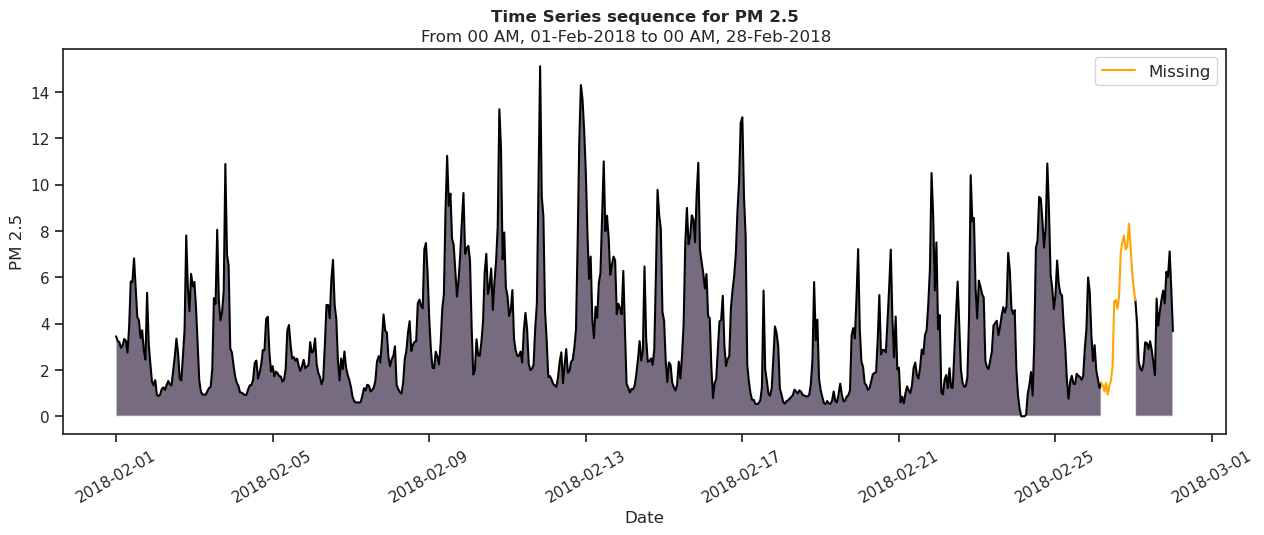

In [159]:
subset, subset_missing = create_missing(
    data=station_subset,
    start=datetime(2018, 2, 1),
    end=datetime(2018, 2, 28),
    missing_length=20,
    padding=24,
    missing_index='end'
)
plot_compare(subset, subset_missing)

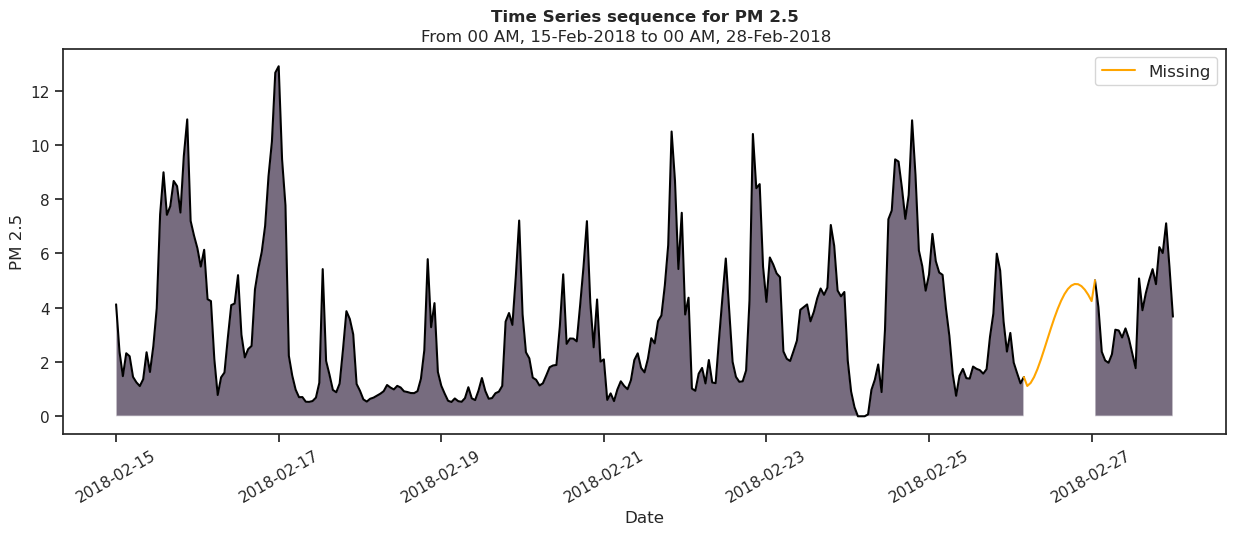

RMSE for RAW_VALUE: 0.3233


0.3233350620750966

In [160]:
subset_spline = subset.copy()
subset_spline['RAW_VALUE'] = subset_missing['RAW_VALUE'].interpolate(method = 'spline', order = 4).tolist()
plot_compare(subset_spline, subset_missing,
             start=datetime(2018, 2, 15),
             end=datetime(2018, 2, 28),
             fill=True)

rmse_score(subset, subset_spline)